<a href="https://colab.research.google.com/github/psu-rdmap/unet-compare/blob/main/unet_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Commit id: c9ba2ed

## Prepare Environment

In [ ]:
!pip install keras --upgrade # need Keras 3.6.0 due to bug with saving/loading utility in default version

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose, MaxPooling2D, Concatenate
from keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
import datetime
from glob import glob
from os import mkdir, listdir, remove
from os.path import join, split, splitext, isdir
import shutil
import random
import re
import cv2
import numpy as np
import time
from keras import backend as K
import gc
import keras
import json
from keras.preprocessing.image import save_img
import pandas as pd
import matplotlib.pyplot as plt
import math
from natsort import os_sorted
from keras.models import load_model

random.seed(229)
AUTOTUNE = tf.data.AUTOTUNE
tf.random.set_seed(3051)

print(keras.__version__)
print(tf.__version__)

3.7.0
2.17.1


# Checkers

In [ ]:
"""
This module handles all operations related to validating user inputs
"""

import os
import datetime


def general(configs : dict):
    """
    Checks configs that are general to all modes

    Parameters
    ----------
    configs : dict
        Input configs defined in the JSON input file

    """

    # set root as absolute path to unet-compare
    configs.update({'root' : '/content/drive/MyDrive/'})


    training_modes = ['Single', 'CrossVal', 'Inference']
    if 'training_mode' not in configs:
        configs.update({'training_mode' : 'Single'})
    else:
        assert configs['training_mode'] in training_modes, 'Provided training_mode is invalid. Choose from: {}, {}, {}'.format(*training_modes)


    if 'dataset_prefix' not in configs:
        configs.update({'dataset_prefix' : 'gb_1024'})
    else:
        assert type(configs['dataset_prefix']) == str, 'dataset_prefix must be a string'
        data_path = os.path.join(configs['root'], 'data/', configs['dataset_prefix'])
        assert os.path.isdir(data_path), 'No directory exists at {}'.format(data_path)


def training(configs : dict):
    """
    Checks configs that are specific to training modes single and cross validation

    Parameters
    ----------
    configs : dict
        Input configs defined in the JSON input file with updates after general()

    """

    encoders = ['UNet', 'EfficientNetB7']
    if 'encoder_name' not in configs:
        configs.update({'encoder_name' : 'UNet'})
    else:
        assert configs['encoder_name'] in encoders, 'Provided encoder_name is invalid. Choose from: {}, {}'.format(*encoders)


    decoders = ['UNet', 'UNet++']
    if 'decoder_name' not in configs:
        configs.update({'decoder_name' : 'UNet'})
    else:
        assert configs['decoder_name'] in decoders, 'Provided decoder_name is invalid. Choose from: {}, {}'.format(*decoders)


    # vanilla UNet encoder needs filter numbers
    if 'encoder_filters' not in configs:
        configs.update({'encoder_filters' : [64, 128, 256, 512, 1024]})
    else:
        assert type(configs['encoder_filters']) == list, 'encoder_filters must be an array of 5 positive integers'
        assert len(configs['encoder_filters']) == 5, 'encoder_filters must have 5 integers'
        assert all([type(filters) == int for filters in configs['encoder_filters']]), 'encoder_filters must be integers'
        assert all([filters > 0 for filters in configs['encoder_filters']]), 'encoder_filters must be positive'


    if 'decoder_filters' not in configs:
        configs.update({'decoder_filters' : [512, 256, 128, 64, 32]})
    else:
        assert type(configs['decoder_filters']) == list, 'decoder_filter must be an array of 5 positive integers'
        assert len(configs['decoder_filters']) == 5, 'decoder_filter must have 4 integers'
        assert all([type(filters) == int for filters in configs['decoder_filters']]), 'decoder_filter must be integers'
        assert all([filters > 0 for filters in configs['decoder_filters']]), 'decoder_filter must be positive'


    if ' freeze_backbone' not in configs:
        configs.update({'freeze_backbone' : False})
    else:
        assert type(configs['batchnorm']) == bool, 'freeze_backbone must be true or false'


    if 'image_ext' not in configs:
        configs.update({'image_ext' : '.jpg'})
    else:
        assert type(configs['image_ext']) == str, 'image_ext must be a string'
        assert configs['image_ext'][0] == '.', 'image_ext must start with \'.\''


    if 'annotation_ext' not in configs:
        configs.update({'annotation_ext' : '.png'})
    else:
        assert type(configs['annotation_ext']) == str, 'annotation_ext must be a string'
        assert configs['annotation_ext'][0] == '.', 'annotation_ext must start with a .'


    if 'learning_rate' not in configs:
        configs.update({'learning_rate' : 1e-4})
    else:
        assert type(configs['learning_rate']) == float, 'learning_rate must be float between 0 and 1'
        assert configs['learning_rate'] > 0, 'learning_rate must be float between 0 and 1'
        assert configs['learning_rate'] < 1, 'learning_rate must be float between 0 and 1'


    if 'l2_reg' not in configs:
        configs.update({'l2_reg' : 0.0})
    else:
        assert type(configs['l2_reg']) == float, 'l2_reg must be a float between 0 (inclusive) and 1'
        assert configs['l2_reg'] >= 0, 'l2_reg must be a float between 0 (inclusive) and 1'
        assert configs['l2_reg'] < 1, 'l2_reg must be a float between 0 (inclusive) and 1'


    if 'batch_size' not in configs:
        configs.update({'batch_size' : 1})
    else:
        assert type(configs['batch_size']) == int, 'batch_size must be a positive integer'
        assert configs['batch_size'] > 0, 'batch_size must be a positive integer'


    if 'num_epochs' not in configs:
        configs.update({'num_epochs' : 50})
    else:
        assert type(configs['num_epochs'] == int), 'num_epochs must be a positive integer'
        assert configs['num_epochs'] > 0, 'num_epochs must be a positive integer'


    if 'batchnorm' not in configs:
        configs.update({'batchnorm' : False})
    else:
        assert type(configs['batchnorm']) == bool, 'batchnorm must be true or false'


    if 'augment' not in configs:
        configs.update({'augment' : True})
    else:
        assert type(configs['augment']) == bool, 'augment must be true or false'


    if 'save_best_only' not in configs:
        configs.update({'save_best_only' : True})
    else:
        assert type(configs['save_best_only']) == bool, 'save_best_only must be true or false'


    if 'standardize' not in configs:
        configs.update({'standardize' : False})
    else:
        assert type(configs['standardize']) == bool, 'standardize must be true or false'

    now = datetime.datetime.now()
    results_dir = 'results_' + configs['dataset_prefix'] + '_' + configs['training_mode'] + '_' + configs['encoder_name'] + '_' + configs['decoder_name'] + now.strftime('_(%Y-%m-%d)_(%H-%M-%S)')
    results_dir = os.path.join(configs['root'], results_dir)
    configs.update({'results' : results_dir})


def single(configs : dict):
    """
    Checks early stopping and val settings

    Parameters
    ----------
    configs : dict
        Input configs defined in the JSON input file with updates after general() and training()

    """

    training(configs)


    if 'early_stopping' not in configs:
        configs.update({'early_stopping' : True})
    else:
        assert type(configs['early_stopping']) == bool, 'early_stopping must be true or false. Set to false if using cross validation'


    if configs['early_stopping']:
        if 'patience' not in configs:
            configs.update({'patience' : 10})
        else:
            assert type(configs['patience']) == int, 'patience must be a positive integer'
            assert configs['patience'] > 0, 'patience must be a positive integer'


    if 'train' not in configs:
        if 'val' not in configs: # train NO, val NO
            configs.update({'auto_split' : True})
            if 'val_hold_out' not in configs:
                raise KeyError('val_hold_out must be provided if no val set is provided. It refers to the percentage of the data to hold out for validation')
            else:
                assert type(configs['val_hold_out'] == float), 'val_hold_out must be a decimal between 0 and 1'
                assert configs['val_hold_out'] > 0, 'val_hold_out must be a decimal between 0 and 1'
                assert configs['val_hold_out'] < 1, 'val_hold_out must be a decimal between 0 and 1'
        else: # train NO, val YES
            assert type(configs['val']) == list, 'val must be an array of strings'
            assert len(configs['val']) > 0, 'At least one validation image filename must be provided if a validation set is provided'
            assert all([type(fn) == str for fn in configs['val']]), 'All elements of the validation filename set must be strings'
            configs.update({'auto_split' : False})
            data_path = os.path.join(configs['root'], 'data/', configs['dataset_prefix'], 'images/')
            train_fns = [os.path.splitext(fn)[0] for fn in os.listdir(data_path)]
            for val_fn in configs['val']: train_fns.remove(val_fn)
            assert len(train_fns) > 0, 'At least one image must be left over for the training set'
            configs.update({'train' : train_fns})
    else:
        configs.update({'auto_split' : False})
        assert type(configs['train']) == list, 'train must be an array of strings'
        assert len(configs['train']) > 0, 'At least one training image filename must be provided'
        assert all([type(fn) == str for fn in configs['train']]), 'All elements of the training filename set must be strings'
        if 'val' not in configs: # train YES, val NO
            data_path = os.path.join(configs['root'], 'data/', configs['dataset_prefix'], 'images/')
            val_fns = [os.path.splitext(fn)[0] for fn in os.listdir(data_path)]
            for train_fn in configs['train']: val_fns.remove(train_fn)
            assert len(val_fns) > 0, 'At least one image must be left over for the validation set'
            configs.update({'val' : val_fns})
        else: # train YES, val YES
            assert type(configs['val']) == list, 'val must be an array of strings'
            assert len(configs['val']) > 0, 'At least one validation image filename must be provided if a validation set is provided'
            assert all([type(fn) == str for fn in configs['val']]), 'All elements of the validation filename set must be strings'
            assert all([val_fn not in configs['train'] for val_fn in configs['val']]), 'Validation filename detected in training set'


    if 'checkpoint_path' in configs:
        assert type(configs['checkpoint_path']) == str, 'If continuing training from a previous model, checkpoint_path must be a path like string to the model .keras file. It should be relative to root'
        model_path = os.path.join(configs['root'], configs['checkpoint_path'])
        assert os.path.exists(model_path), 'Model file does not exist at {}'.format(model_path)
        configs['checkpoint_path'] = model_path
    else:
        configs.update({'checkpoint_path' : None})


def cross_val(configs : dict):
    """
    Checks val settings and for number of folds

    Parameters
    ----------
    configs : dict
        Input configs defined in the JSON input file with updates after general() and training()

    Returns
    -------
    Updated configs : dict
    """

    training(configs)

    configs.update({'early_stopping' : False})
    configs.update({'auto_split' : False})
    configs.update({'checkpoint_path' : None})
    assert 'val' not in configs, 'Do not provide a validation set, if using cross-validation'


    if 'train' not in configs:
        data_path = os.path.join(configs['root'], 'data/', configs['dataset_prefix'], 'images/')
        assert os.path.isdir(data_path), 'Attempted to get retrieve filenames from {}, but the directory does not exist'.format(data_path)
        train_filenames = [os.path.splitext(fn)[0] for fn in os.listdir(data_path)]
        configs.update({'train' : train_filenames})
    else:
        assert type(configs['train']) == list, 'train must be an array of strings'
        assert len(configs['train']) > 0, 'At least one training image filename must be provided'
        assert all([type(fn) == str for fn in configs['train']]), 'All elements of the training filename set must be strings'


    if 'num_folds' not in configs:
        configs.update({'num_folds' : 3})
    else:
        assert type(configs['num_folds']) == int, 'num_folds must be a positive integer greater than 1'
        assert configs['num_folds'] > 1, 'num_folds must be a positive integer greater than 1'
        assert len(configs['train']) >= configs['num_folds'], 'There must be at least as many images as folds'


def inference(configs : dict):
    """
    Checks for model file

    Parameters
    ----------
    configs : dict
        Input configs defined in the JSON input file with updates after general()

    Returns
    -------
    Updated configs : dict
    """

    if 'model_path' not in configs:
        raise KeyError('model_path not provided. It must be a path like string to the model file relative to root')
    else:
        assert type(configs['model_path']) == str, 'model_path must be a path like string to the .keras model file. It should be relative to root'
        model_path = os.path.join(configs['root'], configs['model_path'])
        assert os.path.exists(model_path), 'Model file does not exist at {}'.format(model_path)
        configs['model_path'] = model_path

    now = datetime.datetime.now()
    results_dir = 'results_' + configs['dataset_prefix'] + '_' + configs['training_mode'] + now.strftime('_(%Y-%m-%d)_(%H-%M-%S)')
    results_dir = os.path.join(configs['root'], results_dir)
    configs.update({'results' : results_dir})


# Blocks

In [ ]:
"""
This module handles the definition of the custom convolution layers used in UNet models
"""

def ConvBlock(inputs, filters, batchnorm, l2_reg, index):
    """
    Two Conv2D with optional batchnorm layer and ReLU activation
    """
    def ConvUnit(inputs, layer_index):
        x = Conv2D(filters, 3, padding='same', name='conv_'+layer_index, use_bias=not(batchnorm), kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(inputs)
        if batchnorm:
            x = BatchNormalization(name='bn_'+layer_index)(x)
        return Activation('relu', name='relu_'+layer_index)(x)

    x = ConvUnit(inputs, index+'a')
    return ConvUnit(x, index+'b')


def UpsampleBlock(inputs, filters, batchnorm, l2_reg, index):
    """
    A Conv2DTranspose layer for upsampling with optional batchnorm layer and ReLU activation
    """
    x = Conv2DTranspose(filters, 2, padding='same', name='up_'+index, use_bias=not(batchnorm), kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), strides=2)(inputs)
    if batchnorm:
        x = BatchNormalization(name='bn_'+index)(x)
    return Activation('relu', name='relu_'+index)(x)

# Dataloader

In [ ]:
"""
This module handles all operations related to the loading of data or creation of a training dataset
"""

def create_dataset(configs : dict) -> tuple[dict, int, int]:
    """
    Create the training dataset and return a Tensorflow Dataset instance of it

    Parameters:
    ----------
    configs : dict
        Dictionary containing all data necessary to find the data and build the dataset

    Returns:
    --------
    Training and validation Dataset instances : dict
    Number of train steps : int
    Number of val steps : int
    """

    # create directory structure and remove previous dataset if it was never deleted
    ds_path = join(configs['root'], 'dataset')
    if isdir(ds_path):
        shutil.rmtree(ds_path)
    train_val_paths = create_dstree(ds_path)

    # if auto_split is true, this function will split the data into train/val sets
    split_data(configs)

    # update input shape in configs for model definition
    get_input_shape(configs)

    # copy images into dataset directory
    populate_dstree(configs)

    # augment dataset
    if configs['augment']:
        augment_dataset(configs, train_val_paths['train_path'])

    # create a Tensorflow Dataset object
    return define_dataset(train_val_paths, configs)


def create_dstree(dest : str) -> dict[str, str]:
    """
    Create the directory tree given the top-dataset directory path

    Parameters:
    ----------
    dest : str
        Desired path to dataset

    Returns:
    --------
    Full paths to image train and val sets : dict
    """

    # define directories
    image_dir = join(dest, 'images')
    annotation_dir = join(dest, 'annotations')
    image_train_dir = join(image_dir, 'train')
    image_val_dir = join(image_dir, 'val')
    annotation_train_dir = join(annotation_dir, 'train')
    annotation_val_dir = join(annotation_dir, 'val')

    # run through all directories defined in the function and make them
    for _, dir in locals().items():
        mkdir(dir)

    return {"train_path" : image_train_dir, "val_path" : image_val_dir}


def populate_dstree(configs : dict):
    """
    Copy files from data directory to empty dataset tree

    Parameters:
    ----------
    configs : dict
        Input configs given by the user
    """

    # file sets
    train_images = [image + configs['image_ext'] for image in configs['train']]
    val_images = [image + configs['image_ext'] for image in configs['val']]

    train_annotations = [annotation + configs['annotation_ext'] for annotation in configs['train']]
    val_annotations = [annotation + configs['annotation_ext'] for annotation in configs['val']]

    # source directories
    image_source = join(configs['root'], 'data/', configs['dataset_prefix'], 'images/')
    annotation_source = join(configs['root'], 'data/', configs['dataset_prefix'], 'annotations/')

    # dest directories
    image_train_dest = join(configs['root'], 'dataset/images/train')
    image_val_dest = join(configs['root'], 'dataset/images/val')

    annotation_train_dest = join(configs['root'], 'dataset/annotations/train')
    annotation_val_dest = join(configs['root'], 'dataset/annotations/val')

    # populate directories
    copy_files(train_images, image_source, image_train_dest)
    copy_files(val_images, image_source, image_val_dest)

    copy_files(train_annotations, annotation_source, annotation_train_dest)
    copy_files(val_annotations, annotation_source, annotation_val_dest)


def copy_files(files : list, source : str, dest : str):
    """
    Copies all provided files from a source directory to a destination directory

    Parameters:
    ----------
    files : list
        Filenames in source directory to be copied
    source : str
        Path to current location of files
    dest : str
        Path to where files are to be copied to
    """

    for f in files:
        src = join(source, f)
        shutil.copy(src, dest)


def get_input_shape(configs : dict):
    """
    Adds input shape to configs

    Parameters
    ----------
    configs : dict
        Input configs given by the user
    """

    data_path = join(configs['root'], 'data/', configs['dataset_prefix'], 'images/', configs['train'][0] + configs['image_ext'])
    test_img = cv2.imread(data_path)
    configs.update({'input_shape' : test_img.shape})


def augment_dataset(configs : dict, image_train_path : str):
    """
    Replace each image and annotation with eight geometric augmentations

    Parameters:
    ----------
    configs : dict
        Dictionary with relevant data information (file extensions, etc.)
    image_train_path : str
        Full path to training images in created dataset directory
    """

    # loop through training images (use glob to get full path to each image)
    for img in glob(join(image_train_path, '*')):
        # replace images in path with annotations and image extension to annotation extension
        ann = re.sub('images', 'annotations', img)
        ann = re.sub(configs['image_ext'], configs['annotation_ext'], ann)

        # augment image and annotation
        augment_single_image(img)
        augment_single_image(ann)


def augment_single_image(file_full_path : str):
    """
    Performs and saves eight unique geometric transformations on a given image then deletes the original image

    Parameters:
    ----------
    file_full_path : str
        Absolute path to a given file
    """

    # get file path pieces
    path, fn_ext = split(file_full_path)
    fn, ext = splitext(fn_ext)

    # load file
    file = cv2.imread(file_full_path)

    # perform transformations on file
    file_1 = file                                              # original
    file_2 = cv2.rotate(file, cv2.ROTATE_90_CLOCKWISE)         # rot90
    file_3 = cv2.rotate(file, cv2.ROTATE_180)                  # rot180
    file_4 = cv2.rotate(file, cv2.ROTATE_90_COUNTERCLOCKWISE)  # rot270
    file_5 = cv2.flip(file, 1)                                 # xflip
    file_6 = cv2.flip(file_2, 1)                               # rot90 + xflip
    file_7 = cv2.flip(file_2, 0)                               # rot90 + yflip
    file_8 = cv2.flip(file_3, 1)                               # rot180 + xflip

    # save augmentations
    cv2.imwrite(join(path, fn + '_1' + ext), file_1)
    cv2.imwrite(join(path, fn + '_2' + ext), file_2)
    cv2.imwrite(join(path, fn + '_3' + ext), file_3)
    cv2.imwrite(join(path, fn + '_4' + ext), file_4)
    cv2.imwrite(join(path, fn + '_5' + ext), file_5)
    cv2.imwrite(join(path, fn + '_6' + ext), file_6)
    cv2.imwrite(join(path, fn + '_7' + ext), file_7)
    cv2.imwrite(join(path, fn + '_8' + ext), file_8)

    # remove original image and label
    remove(file_full_path)


def define_dataset(train_val_paths : dict, configs : dict) -> tuple[dict, int, int]:
    """
    Use created dataset to define Tensorflow Dataset instances for the training and validation sets

    Parameters:
    ----------
    train_val_paths : dict
        A dictionary containing paths to dataset train/val directories (e.g. dataset/images/train)
    configs : dict
        Dictionary containing all data necessary to find the data and build the dataset

    Returns:
    --------
    dataset : dict
        Dictionary of training and validation instantiated Dataset objects
    train_steps : int
        Number of steps to take when training for a single pass over all available training data
    val_steps : int
        Number of steps to take during evaluation of the validation set after an epoch has completed
    """

    # get size of training and validation sets
    train_size = len(listdir(train_val_paths['train_path']))
    val_size = len(listdir(train_val_paths['val_path']))

    # initialize Dataset objects with a list of filenames
    train_dataset = tf.data.Dataset.list_files(train_val_paths['train_path'] + '/*' + configs['image_ext'])
    val_dataset = tf.data.Dataset.list_files(train_val_paths['val_path'] + '/*' + configs['image_ext'])

    # replace every image path in the training and validation directories with a loaded image and annotation pair
    train_dataset = train_dataset.map(lambda x: parse_image(x, configs), num_parallel_calls=AUTOTUNE)
    val_dataset = val_dataset.map(lambda x: parse_image(x, configs), num_parallel_calls=AUTOTUNE)

    if configs['standardize']:
        # get statistics for standardization (only from train) and apply to each train/val image set
        m, s = get_ds_stats(train_dataset)
        train_dataset = train_dataset.map(lambda image, annotation : ((image - m) / s, annotation))
        val_dataset = val_dataset.map(lambda image, annotation : ((image - m) / s, annotation))

    BUFFER_SIZE = 48

    # define dict to contain Dataset instances
    dataset = {"train": train_dataset, "val": val_dataset}

    # shuffle the training dataset and batch it
    dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE)
    dataset['train'] = dataset['train'].repeat()
    dataset['train'] = dataset['train'].batch(configs['batch_size'])
    dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

    # batch the validation dataset
    dataset['val'] = dataset['val'].repeat()
    dataset['val'] = dataset['val'].batch(1)
    dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

    # determine number of steps to take in an epoch
    train_steps = train_size // configs['batch_size']
    val_steps = val_size // 1

    return dataset, train_steps, val_steps


def parse_image(img_path : tf.string, configs : dict) -> tuple[tf.Tensor, tf.Tensor]:
    """
    Load an image and its annotation then resize it and normalize it

    Parameters:
    ----------
    img_path : tf.str
        Path to a given image to be loaded
    data_cfgs : dict
        Dictionary containing all info necessary to load and pre-process an image

    Returns:
    --------
    Loaded image and annotation pair : tf.Tensor, tf.Tensor
    """

    # read image and load it into 3 channels (pre-trained backbones require 3)
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)

    # adjust path to lead to the corresponding annotation and load it
    annotation_path = tf.strings.regex_replace(img_path, "images", "annotations")
    annotation_path = tf.strings.regex_replace(annotation_path, configs['image_ext'], configs['annotation_ext'])
    annotation = tf.io.read_file(annotation_path)
    annotation = tf.image.decode_png(annotation, channels=1)

    # convert tensor objects to floats and normalize images ([0,255] -> [0.0, 1.0])
    image = tf.cast(image, tf.float32) / 255.0
    annotation = tf.cast(annotation, tf.float32) / 255.0

    # return two Tensor objects with loaded image and annotation data
    return image, annotation


def get_ds_stats(dataset : tf.data.Dataset) -> tuple[tf.Tensor, tf.Tensor]:
    """
    Computes mean and standard deviation for standardization of grayscale images

    Parameters
    ----------
    dataset : tf.data.Dataset
        Dataset object with image/annotation pairs as elements

    Returns
    -------
    Dataset mean and standard deviation for each channel : tf.Tensor, tf.Tensor
    """

    img_count, mean, std = 0, tf.zeros(3), tf.zeros(3)

    for image, __ in dataset:
        mean += tf.math.reduce_mean(image, axis=[0,1])
        std += tf.math.reduce_std(image, axis=[0,1])
        img_count += 1

    mean /= img_count
    std /= img_count

    return mean, std


def split_data(configs : dict):
    """
    Add training and validation sets to configs if necessary

    Parameters:
    ----------
    configs : dict
        Information required to generate training and validation sets

    Returns:
    --------
    configs : dict
        Updated configs w/ train/val sets
    """

    # case 1: auto_split is on and training filenames are provided
    if (configs['auto_split'] == True) and ('train' in configs):
        # randomly select training and validation subsets
        train_fns, val_fns = auto_split(configs['train'], configs['val_hold_out'])

        # overwrite training filename list and add new val filename list
        configs['train'] = train_fns
        configs.update({'val' : val_fns})

    # case 2: auto_split is on and no training filenames are provided
    elif configs['auto_split'] == True:
        # get fns from image file source
        fns_path = join(configs['root'], 'data/', configs['dataset_prefix'], 'images/')
        fns = listdir(fns_path)

        fns = [splitext(split(fn)[1])[0] for fn in fns]

        # randomly select training and validation subsets
        train_fns, val_fns = auto_split(fns, configs['val_hold_out'])

        # add train and val filename lists
        configs.update({'train' : train_fns})
        configs.update({'val' : val_fns})

    # case 3: data is already split and provided by the user
    else:
        pass


def auto_split(fns : list, val_hold_out : dict) -> tuple[list, list]:
    """
    Randomly select subsets of the fns list for training and validation

    Parameters:
    ----------
    fns : list
        List of filenames to be split
    val_hold_out : dict
        Fraction of files to be held out for validation

    Returns:
    --------
    train_fns : list
        Filenames to be used for training
    val_fns : list
        Filenames to be used for validation
    """

    # shuffle images to prevent sequence bias
    random.shuffle(fns)

    # upper/lower bounds
    train_lower = 0
    train_upper = int(len(fns)*(1-val_hold_out))

    val_lower = train_upper
    val_upper = len(fns)

    # define and return new filenames sets
    train_fns = fns[train_lower : train_upper]
    val_fns = fns[val_lower : val_upper]

    return train_fns, val_fns

# Models

In [ ]:
"""
This module handles the definition of encoder/decoder subnetworks and their connection
"""

def UNet(configs : dict):
    """
    U-Net built with Functional API using either U-Net or EfficientNetB7 encoders and either U-Net or U-Net++ decoders

    Parameters
    ----------
    configs : dict
        Input configs defined in the JSON input file

    Returns
    -------
    Keras Functional model representing the UNet : tf.keras.Model
    """

    enc_filters = configs['encoder_filters']
    dec_filters = configs['decoder_filters']
    batchnorm = configs['batchnorm']
    l2_reg = configs['l2_reg']

    input = keras.Input(shape = configs['input_shape'], name = 'main_input')

    # encoder
    if configs['encoder_name'] == 'UNet':
        model_name = 'UNet'
        x = input
        enc_outputs = []
        for idx, filters in enumerate(enc_filters):
            name_idx = f'{idx}0'
            # conv
            x = ConvBlock(x, filters, batchnorm, l2_reg, name_idx)
            enc_outputs.append(x)
            # pool
            if idx < 4:
                x = MaxPooling2D(pool_size=2, name = 'pool_'+name_idx)(x)


    elif configs['encoder_name'] == 'EfficientNetB7':
        model_name = 'EfficientNet'
        backbone = EfficientNetB7(include_top = False, weights = 'imagenet', input_tensor = input)

        # freeze entire backbone or just batchnorm layers
        if configs['freeze_backbone']:
            for layer in backbone.layers:
                layer.trainable = False
        else:
            for layer in backbone.layers:
                if isinstance(layer, tf.keras.layers.BatchNormalization):
                    layer.trainable = False

        enc_stages = ['stem_activation', 'block2g_add', 'block3g_add', 'block5j_add', 'block7d_add']
        enc_outputs = [backbone.get_layer(stage).output for stage in enc_stages]


    # decoder
    enc_outputs.reverse()
    if configs['decoder_name'] == 'UNet':
        model_name += '-UNet'
        x = enc_outputs[0]
        for idx, filters in enumerate(dec_filters[:-1]):
            name_idx = f'{3-idx}{idx+1}' # 31, 22, 13, 04
            x = UpsampleBlock(x, dec_filters[idx], batchnorm, l2_reg, name_idx)
            x = Concatenate(name='cat_'+name_idx)([x, enc_outputs[idx+1]])
            x = ConvBlock(x, dec_filters[idx], batchnorm, l2_reg, name_idx)

    elif configs['decoder_name'] == 'UNet++':
        model_name += '-UNetpp'
        prev_row_outs = [enc_outputs[0]]
        for row in range(4): # number of rows
            current_row_outs = [enc_outputs[row+1]]
            for node in range(row+1): # 1, 2, 3, 4 nodes per row
                name_idx = f'{3-row}{node+1}' # 31, 21, 22, 11, 12, 13, 01, 02, 03, 04
                x = UpsampleBlock(prev_row_outs[node], dec_filters[row], batchnorm, l2_reg, name_idx)
                x = Concatenate(name='cat_'+name_idx)([x] + current_row_outs[:(node+1)])
                x = ConvBlock(x, dec_filters[row], batchnorm, l2_reg, name_idx)
                current_row_outs.append(x)
            prev_row_outs = current_row_outs

    # final layers
    if configs['encoder_name'] == 'EfficientNetB7':
        x = UpsampleBlock(x, dec_filters[4], batchnorm, l2_reg, 'final') # upsamples back to original resolution
    sigmoid = Conv2D(1, 1, activation='sigmoid', name='main_output', kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(l2_reg))(x)

    return keras.Model(inputs=input, outputs=sigmoid, name = model_name)

# Modes

In [ ]:
"""
This module handles the training/inference process
"""

def single_mode(configs : dict):
    """
    Runs a single epoch-based training loop

    Parameters
    ----------
    configs : dict
        Input configs provided by the user
    """

    # get dataset
    print('\nCreating dataset...')
    dataset, train_steps, val_steps = create_dataset(configs)
    print('\nTraining images: ', configs['train'])
    print('Validation images:', configs['val'])

    # get model
    print('\nLoading model...')
    if configs['checkpoint_path'] is not None:
        model = keras.load_model(configs['checkpoint_path'])
    else:
        model = UNet(configs)
        model.compile(optimizer = Adam(learning_rate=configs['learning_rate']), loss = 'binary_crossentropy', metrics = ['accuracy', 'Precision', 'Recall'])

    callbacks = [
        CSVLogger(join(configs['results'], 'metrics.csv'), separator=',', append=False),
        ModelCheckpoint(join(configs['results'], 'best.model.keras'), verbose=1, save_best_only=configs['save_best_only'], save_weights_only=False)
    ]
    if configs['early_stopping']:
        callbacks.append(EarlyStopping(patience = configs['patience']))

    # training
    print('\nStarting training loop...\n')
    model.fit(
        dataset['train'],
        epochs=configs['num_epochs'],
        steps_per_epoch=train_steps,
        validation_steps=val_steps,
        validation_data=dataset['val'],
        callbacks=callbacks,
        verbose=1 # 1 = live progress bar, 2 = one line per epoch
    )

    # load model corresponding to minimum val loss
    if configs['save_best_only']:
        model = keras.saving.load_model(join(configs['results'], 'best.model.keras'))

    # inferences train/val sets and save results into results
    print('\nInferencing image sets...')
    inference_ds(configs, model)

    # plot loss, precision, recall, and f1
    print('\nPlotting metrics...')
    plot_results(configs)

    # remove training dataset and clear memory
    print('\nCleaning up...')
    shutil.rmtree(join(configs['root'], 'dataset'))
    K.clear_session()
    gc.collect()

    if configs['training_mode'] == 'Single':
        print('\nDone.')


def cross_val_mode(configs : dict):
    """
    Runs single training mode many times on different hold out sets

    Parameters
    ----------
    configs : dict
        Input configs provided by the user
    """

    # determine all training and val set combinations given the number of folds
    train_sets, val_sets = create_folds(configs['train'], configs['num_folds'])

    # save original results directory
    top_level_results = configs['results']

    # loop through folds
    for fold in range(configs['num_folds']):
        # update train/val sets
        configs.update({'train' : train_sets[fold]})
        configs.update({'val' : val_sets[fold]})

        # create results directory for this fold
        results_dir = 'fold_' + str(fold+1)
        results_dir = join(configs['results'], results_dir)
        configs.update({'results' : results_dir})
        mkdir(results_dir)

        print()
        print('-'*30 + ' Fold {} '.format(fold+1) + '-'*30)

        # train fold
        single_mode(configs)

        # reset results directory for next fold
        configs.update({'results' : top_level_results})

    # plot metrics over all folds
    print('\nPlotting CV Metrics...')
    cv_plot_results(configs)

    configs.pop('val')

    print('\nDone.')


def inference_mode(configs : dict):
    """
    Feeds images into a trained model and saves predictions

    Parameters
    ----------
    configs : dict
        Input configs provided by the user
    """

    print('Loading images...')

    # define path to images and retrieve filenames
    data_path = join(configs['root'], 'data/', configs['dataset_prefix'])
    ds_fns = listdir(data_path)

    # create tensorflow ds
    ds = [join(data_path, fn) for fn in ds_fns]
    ds = tf.data.Dataset.from_tensor_slices(ds)
    ds = ds.map(utils.parse_inference_image)

    # build model and load weights
    print('\nLoading model...')
    model = keras.saving.load_model(configs['model_path'])

    # create and save predictions
    print('\nGenerating predictions and saving them...\n')
    preds = model.predict(ds, verbose=2)
    save_fns = [join(configs['results'], split(fn)[0], '.png') for fn in ds_fns]
    utils.save_preds(preds, save_fns)

    print('\nDone.')

# Utils

In [ ]:
"""
This module handles all accessory operations such as plotting and inference
"""

def parse_inference_image(img_path : str) -> tf.Tensor:
    """
    Given the full path to an image (/path/to/image.ext), load it into a tensor

    Parameters
    ----------
    img_path : str
        Full path to image file

    Returns
    -------
    Loaded image : tf.Tensor
    """

    # read image and load it into 3 channels (pre-trained backbones require 3)
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)

    # convert tensor objects to floats and normalize images ([0,255] -> [0.0, 1.0]) and return tensor
    return tf.cast(image, tf.float32) / 255.0


def save_preds(preds : tf.Tensor, save_fns : list):
    """
    Save each prediction from a tensor of predictions

    Parameters
    ----------
    preds : tf.Tensor
        Tensor of predictions with shape (N, H, W, 1) where N is the number of predictions
    save_fns : list
        List of corresponding image filenames
    """

    for idx, pred in enumerate(preds):
        save_img(save_fns[idx], pred)


def inference_ds(configs : dict, model : tf.keras.Model):
    """
    Inferences and saves every training/validation image after training

    Parameters
    ----------
    configs : dict
        Input configs given by the user
    model : tf.keras.Model
        Trained neural network
    """

    data_path = os.path.join(configs['root'], 'data/', configs['dataset_prefix'], 'images/')

    # define training and validation dataset
    train_ds = tf.data.Dataset.from_tensor_slices([data_path + img + configs['image_ext'] for img in configs['train']])
    val_ds = tf.data.Dataset.from_tensor_slices([data_path + img + configs['image_ext'] for img in configs['val']])

    # replace every image path in the training and validation directories with a loaded image and annotation pair
    train_ds = train_ds.map(parse_inference_image)
    val_ds = val_ds.map(parse_inference_image)

    # batch data
    train_ds = train_ds.batch(1)
    val_ds = val_ds.batch(1)

    # get predictions
    train_preds = model.predict(train_ds, verbose=1)
    val_preds = model.predict(val_ds, verbose=1)

    # define output directories
    train_save_dir = os.path.join(configs['results'], 'train_preds')
    os.mkdir(train_save_dir)
    train_save_fns = [os.path.join(train_save_dir, fn + '.png') for fn in configs['train']]

    val_save_dir = os.path.join(configs['results'], 'val_preds')
    os.mkdir(val_save_dir)
    val_save_fns = [os.path.join(val_save_dir, fn + '.png') for fn in configs['val']]

    # save train and val preds
    save_preds(train_preds, train_save_fns)
    save_preds(val_preds, val_save_fns)


def plot_results(configs : dict):
    """
    Loads training metrics from a single training loop, plots them, and saves it into the results directory

    Parameters
    ----------
    configs : dict
        Input configs given by the user
    """

    # paths
    metrics_path = os.path.join(configs['results'], 'metrics.csv')
    plot_save_path = os.path.join(configs['results'], 'metrics.png')

    # read metrics into dataframe
    metrics = pd.read_csv(metrics_path)

    # get num epochs, and redefine it offset by 1
    num_epochs = metrics['epoch'].count()
    metrics['epoch'] = metrics['epoch'] + 1

    # determine lowest val loss index (where val loss is closest to min(val_loss))
    best_idx = np.where(np.isclose(metrics['val_loss'], min(metrics['val_loss'])))[0]

    # add f1 columns to the dataframe
    metrics['f1'] = add_f1(metrics)
    metrics['val_f1'] = add_f1(metrics, val = True)

    # generate subplots
    fig, axs = plt.subplots(4, 1, figsize=(12,20))

    titles = ['BCE Loss', 'Precision', 'Recall', 'F1-Score']
    y_axes = ['loss', 'Precision', 'Recall', 'f1']

    for i in range(len(axs)):
        y1 = y_axes[i]
        y2 = 'val_' + y1

        # plot metric curve
        axs[i].plot(metrics['epoch'], metrics[y1], '-o',  label='Train')
        axs[i].plot(metrics['epoch'], metrics[y2], '-o', label='Val')

        # add point corresponding to lowest val loss on each curve
        axs[i].plot(best_idx + 1, metrics[y1].iloc[best_idx], 'D', color='purple')
        axs[i].plot(best_idx + 1, metrics[y2].iloc[best_idx], 'D', color='purple', label='Min Val Loss')

        # misc settings
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel(titles[i])
        axs[i].set_xlim([1,num_epochs])
        if i == 0:
            axs[i].set_yscale('log')
        else:
            axs[i].set_yticks(ticks=np.arange(0,1.1,0.1))
        axs[i].grid(visible=True)
        axs[i].legend()

    fig.savefig(plot_save_path, bbox_inches="tight")


def add_f1(metrics : pd.DataFrame, val = False) -> pd.DataFrame:
    """
    Calculates the f1-score element-wise given columns of the dataframe

    Parameters
    ----------
    metrics : pd.DataFrame
        Metrics from the csv file made while training
    val : bool
        Whether the metrics correspond to the validation (true) or training (false) set

    Returns
    -------
    New metrics DataFrame column with f1 values : pd.DataFrame
    """

    if val == True:
        p = 'val_Precision'
        r = 'val_Recall'
    else:
        p = 'Precision'
        r = 'Recall'

    # if the denominator is 0, then f1=0, otherwise it is the harmonic mean
    return np.where(metrics[p] + metrics[r] == 0, 0, 2  * (metrics[p] * metrics[r]) / (metrics[p] + metrics[r]))


def cv_plot_results(configs : dict):
    """
    Loads in metrics for every fold, plots loss curves together, and plots statistics for each epoch

    Parameters
    ----------
    configs : dict
        Input configs given by the user
    """

    # paths
    loss_save_path = os.path.join(configs['results'], 'loss.png')
    metrics_save_path = os.path.join(configs['results'], 'metrics.png')

    # get fold directory names and sort them using natural sorting
    fold_dirs = glob(os.path.join(configs['results'], 'fold_*/'))
    fold_dirs = os_sorted(fold_dirs)

    # dict to hold dataframes for each fold
    all_metrics = []
    for fold in range(len(fold_dirs)):
        # get metrics from csv
        fold_metrics = pd.read_csv(os.path.join(fold_dirs[fold], 'metrics.csv'))

        # add f1 columns to the dataframe
        fold_metrics['f1'] = add_f1(fold_metrics)
        fold_metrics['val_f1'] = add_f1(fold_metrics, val = True)

        # convert to np array and add metrics array to list
        fold_metrics_np = fold_metrics.to_numpy()
        all_metrics.append(fold_metrics_np)

    # stack all metrics arrays along a new 3d axis
    all_metrics = np.stack(all_metrics, axis=0)

    # get epochs list (always the same)
    epochs = all_metrics[0, :, 0].astype(int) + 1

    # plot loss curves together on two separate plots
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))

    for fold in range(configs['num_folds']):
        # train/val losses
        train_loss = all_metrics[fold, :, 4]
        val_loss = all_metrics[fold, :, 8]

        # plot losses
        axs[0].plot(epochs, train_loss, label = 'Fold {}'.format(fold+1))
        axs[1].plot(epochs, val_loss, label = 'Fold {}'.format(fold+1))

    # formatting
    axs[0].set_ylabel('Train Loss (BCE)')
    axs[1].set_ylabel('Val Loss (BCE)')
    for ax in axs:
        ax.set_yscale('log')
        ax.set_xlim([1, configs['num_epochs']])
        ax.set_xlabel('Epoch')
        ax.grid(visible=True)
        ax.legend()

    fig.savefig(loss_save_path, bbox_inches="tight")

    # get mean and stdev across all folds
    num_metrics = np.shape(all_metrics)[-1]
    metrics_mean = np.zeros((configs['num_epochs'], num_metrics))
    metrics_std = np.zeros((configs['num_epochs'], num_metrics))

    for metric in range(num_metrics):
        for epoch in range(configs['num_epochs']):
            metrics_mean[epoch, metric] = np.mean(all_metrics[:, epoch, metric])
            metrics_std[epoch, metric] = np.std(all_metrics[:, epoch, metric])

    # plot averaged metrics with std as error bars
    fig, axs = plt.subplots(4, 1, figsize=(12, 20))

    # settings specific to each plot
    titles = ['BCE Loss', 'Precision', 'Recall', 'F1-Score']
    train_metrics_idcs = [4, 1, 2, 9]
    val_metrics_idcs = [8, 5, 6, 10]

    for i in range(len(axs)):
        # means and stds
        train_mean = metrics_mean[:, train_metrics_idcs[i]]
        val_mean = metrics_mean[:, val_metrics_idcs[i]]

        train_std = metrics_std[:, train_metrics_idcs[i]]
        val_std = metrics_std[:, val_metrics_idcs[i]]

        # plot mean
        axs[i].errorbar(epochs, train_mean, yerr=train_std, fmt='-o', capsize=3, capthick=1, label='Train')
        axs[i].errorbar(epochs, val_mean, yerr=val_std, fmt='-o', capsize=3, capthick=1, label='Val')

        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel(titles[i])
        axs[i].set_xlim([1, configs['num_epochs']])
        if i == 0:
            axs[i].set_yscale('log')
        else:
            axs[i].set_yticks(ticks=np.arange(0,1.1,0.1))
        axs[i].grid(visible=True)
        axs[i].legend()

    fig.savefig(metrics_save_path, bbox_inches="tight")


def create_folds(img_list : list, num_folds : int) -> tuple[list, list]:
    """
    Given images and the number of folds, create training/validation sets with the most even distribution possible

    Parameters
    ----------
    img_list : list
        List of filenames that will be used for cross-validation
    num_folds : int
        Number of training/validation sets to generate

    Returns
    -------
    Training set for each fold : list
    Validation set for each fold : list
    """

    # number of validation images to be held out in each fold
    num_val = np.zeros(num_folds)

    # randomly shuffle the image list given a numpy seed to prevent sequence bias
    np.random.seed(203)
    img_list = np.random.permutation(img_list)

    # determine number of hold out images in each fold
    for i in range(num_folds):
        # start with integer quotient
        num_val[i] = math.floor(len(img_list) / num_folds)
        # distribute the remainder evenly among the first folds
        if i < (len(img_list) % num_folds):
            num_val[i] += 1

    # convert number of hold out images to indicies
    running_sum = np.cumsum(num_val)
    running_sum = np.insert(running_sum, 0, 0)
    lower_idxs = running_sum[:-1].astype(int)
    upper_idxs = running_sum[1:].astype(int)

    # save train/val sets as elements of a list
    train_sets, val_sets = [0]*num_folds, [0]*num_folds
    for i in range(num_folds):
        # bounds
        low = lower_idxs[i]
        up = upper_idxs[i]

        # fold val set
        val_sets[i] = img_list[low:up]

        # fold train set is the complement
        train_sets[i] = np.delete(img_list, np.arange(low, up)).tolist()

    return train_sets, val_sets

# Train

In [ ]:
# EfficientNet training (single loop)

configs = {
    "training_mode" : "CrossVal",
    "encoder_name" : "EfficientNetB7",
    "freeze_backbone" : False,
    "decoder_name" : "UNet",
    "l2_reg" : 0.0005,
    "num_epochs" : 100,
    "num_folds" : 5,
    "dataset_prefix" : "gb_512",
    "batch_size" : 4,
    #"val" : ["11_4", "1_2", "24_1", "4_2", "16_4", "14_4", "11_1", "30_1", "12_1", "1_3", "26_4", "30_4", "14_3", "31_4", "16_2", "4_1", "1_1", "7_3", "25_4", "30_3", "16_3", "14_1", "30_2"]
}


Checking user input...

-------------------------------------------------- User Input --------------------------------------------------
training_mode: CrossVal
encoder_name: EfficientNetB7
freeze_backbone: False
decoder_name: UNet
l2_reg: 0.0005
num_epochs: 100
num_folds: 5
dataset_prefix: gb_512
batch_size: 4
root: /content/drive/MyDrive/
encoder_filters: [64, 128, 256, 512, 1024]
decoder_filters: [512, 256, 128, 64, 32]
image_ext: .jpg
annotation_ext: .png
learning_rate: 0.0001
batchnorm: False
augment: True
save_best_only: True
standardize: False
results: /content/drive/MyDrive/results_gb_512_CrossVal_EfficientNetB7_UNet_(2024-12-05)_(15-43-45)
early_stopping: False
auto_split: False
checkpoint_path: None
train: ['9_4', '4_2', '12_3', '12_1', '24_1', '4_1', '26_3', '11_3', '1_4', '1_3', '7_4', '7_1', '30_3', '25_1', '1_2', '31_2', '24_2', '12_4', '25_3', '9_3', '5_1', '11_4', '5_3', '31_1', '24_4', '26_1', '9_1', '5_4', '5_2', '1_1', '16_1', '25_2', '26_4', '11_1', '4_3', '30_2', 

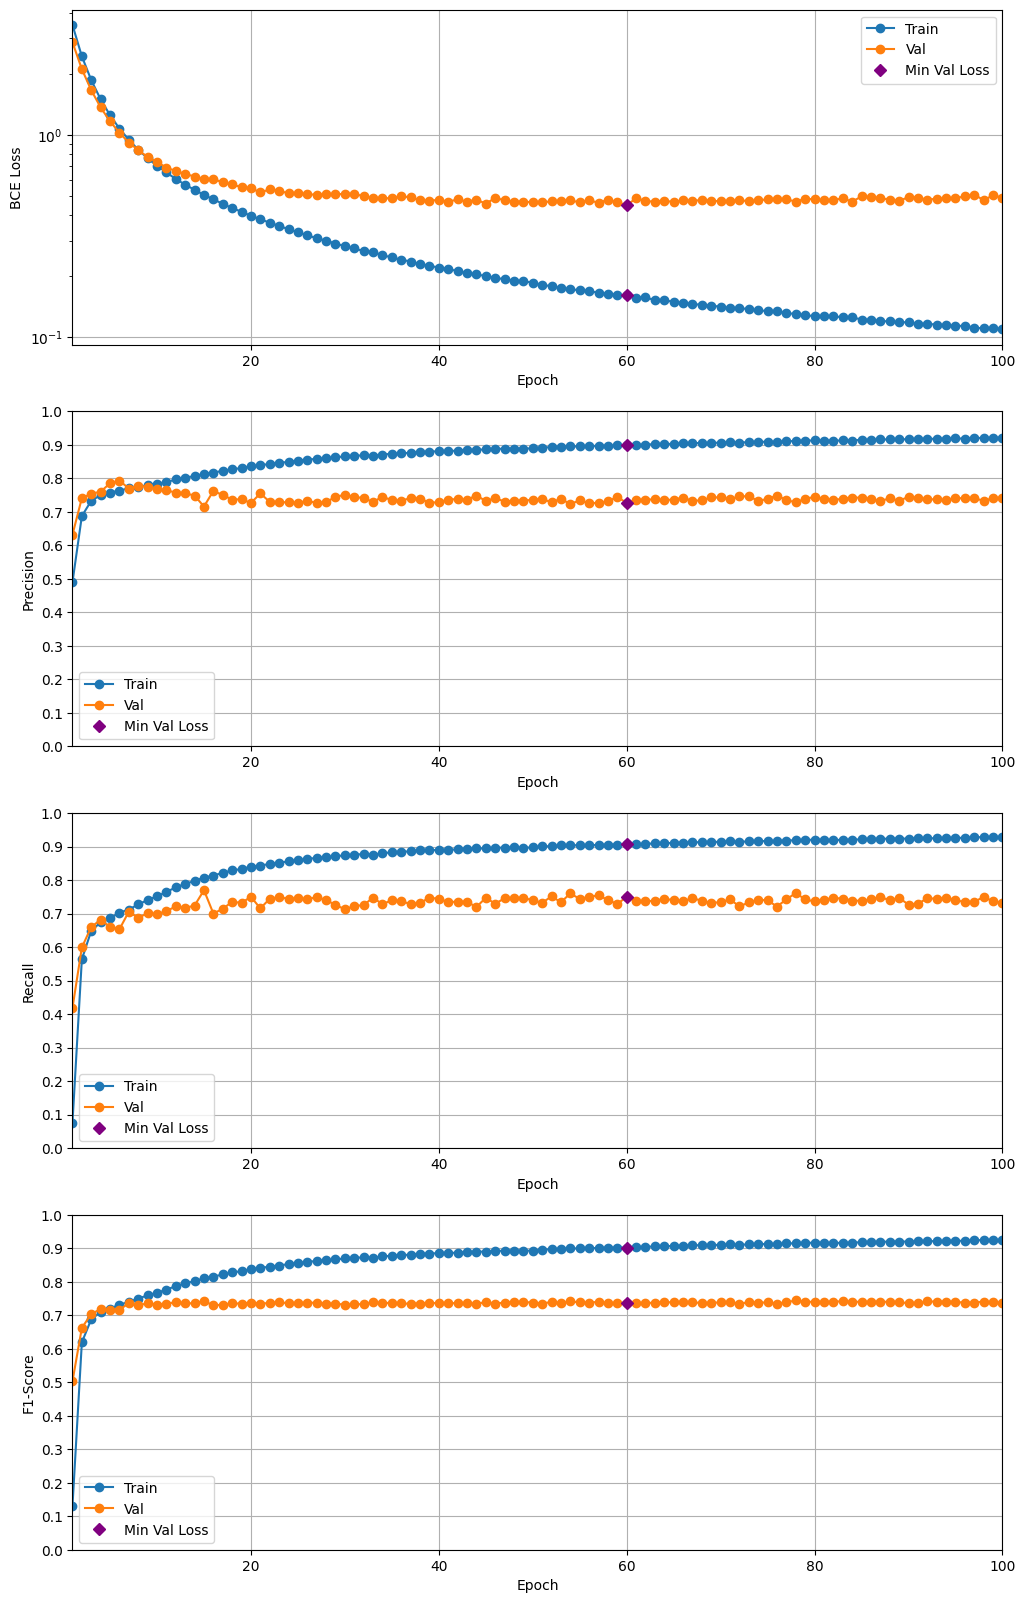

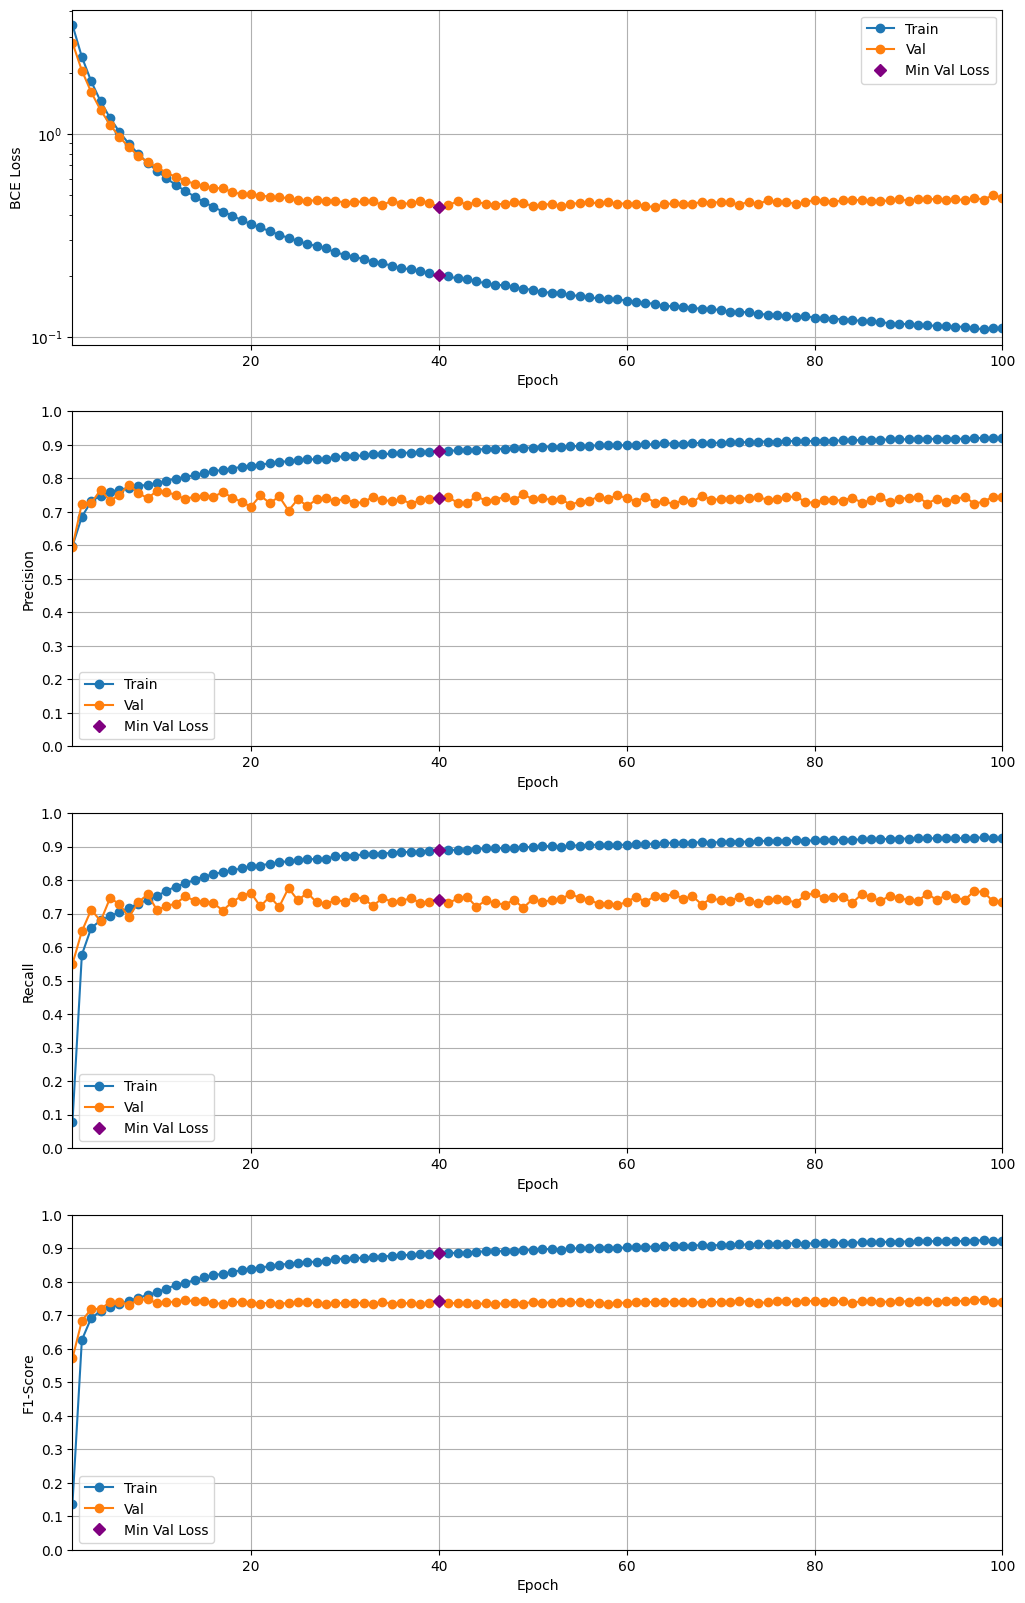

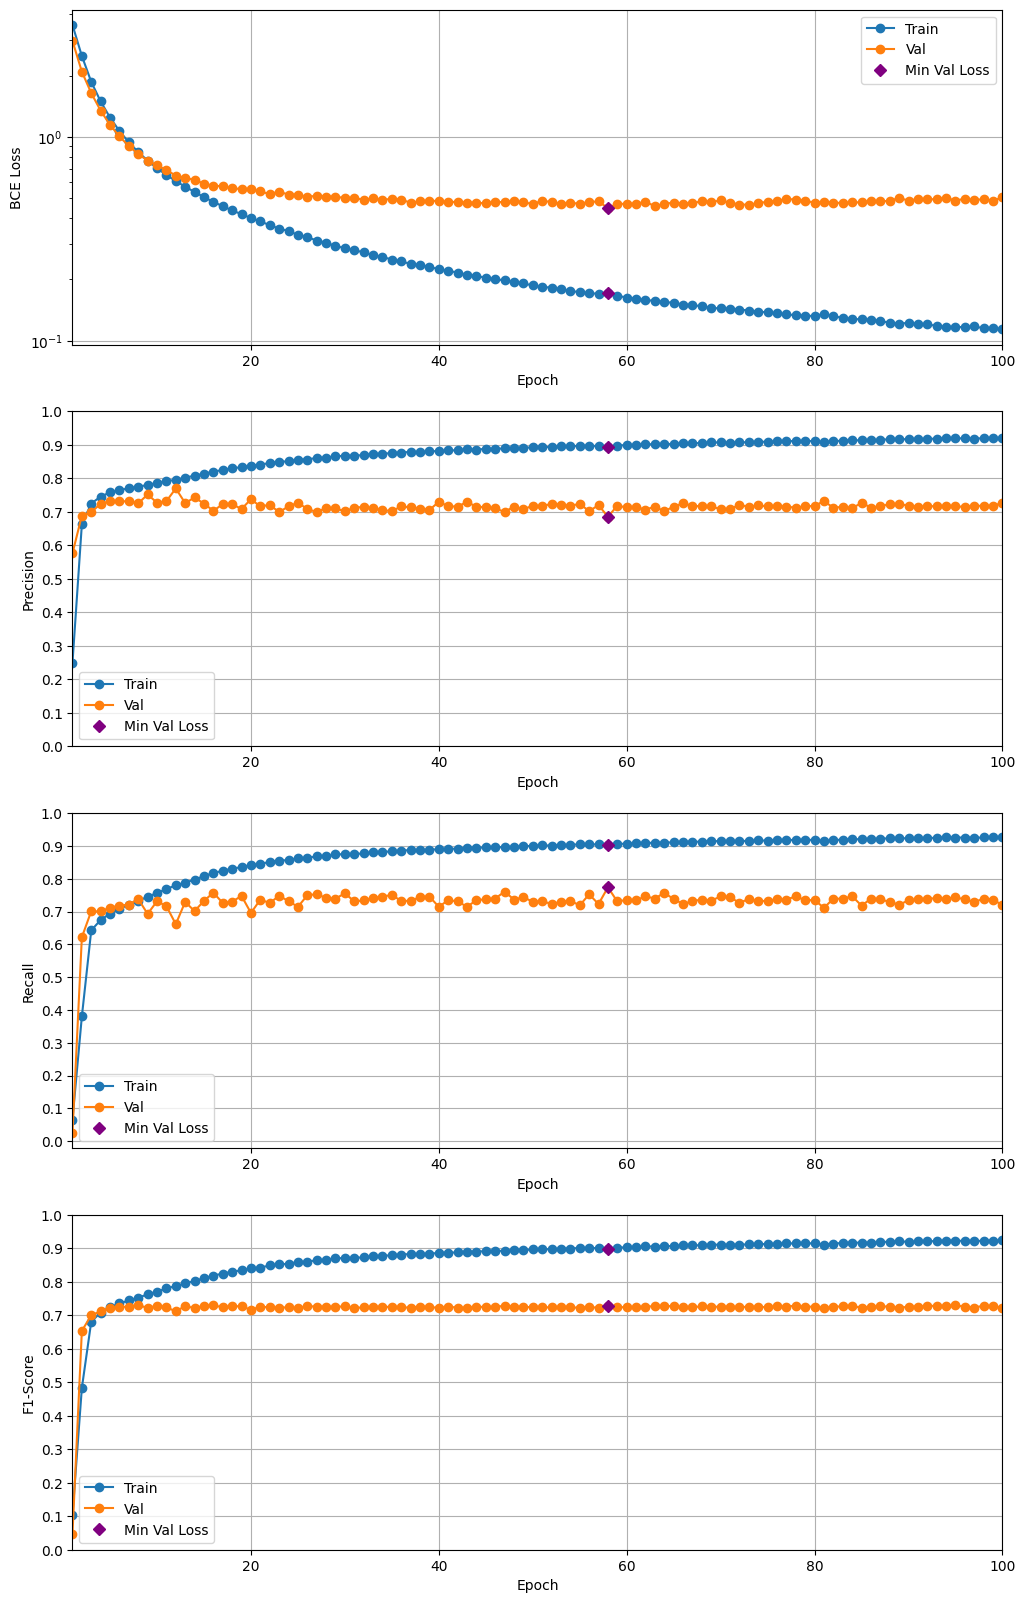

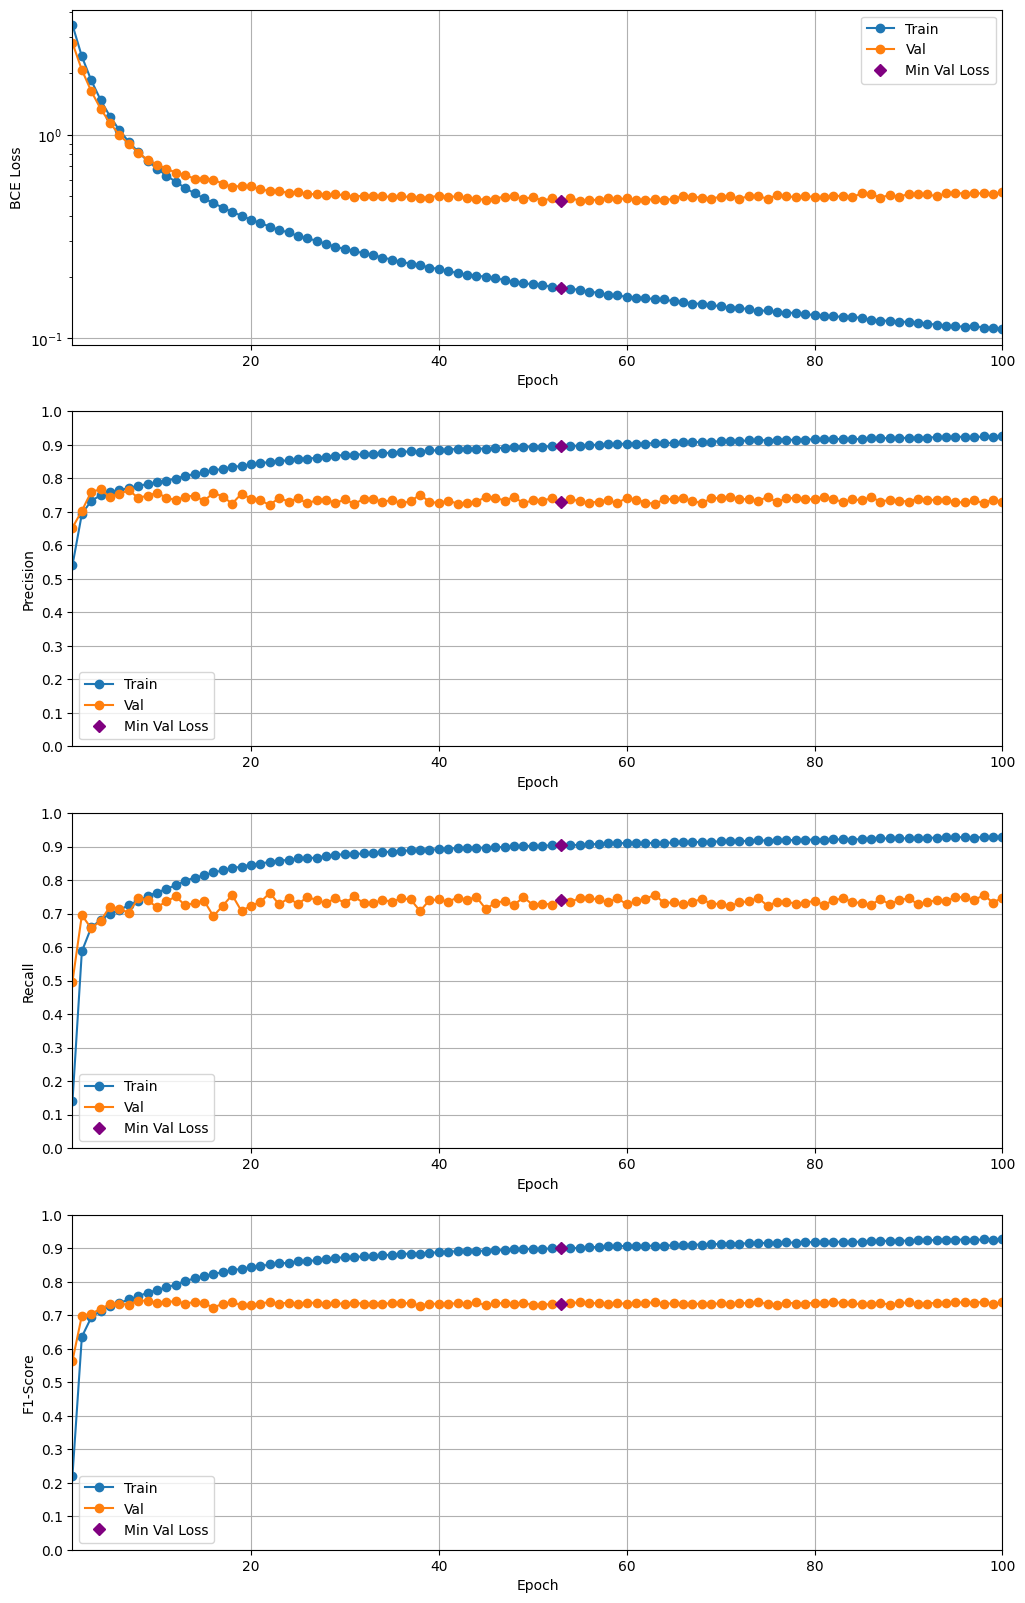

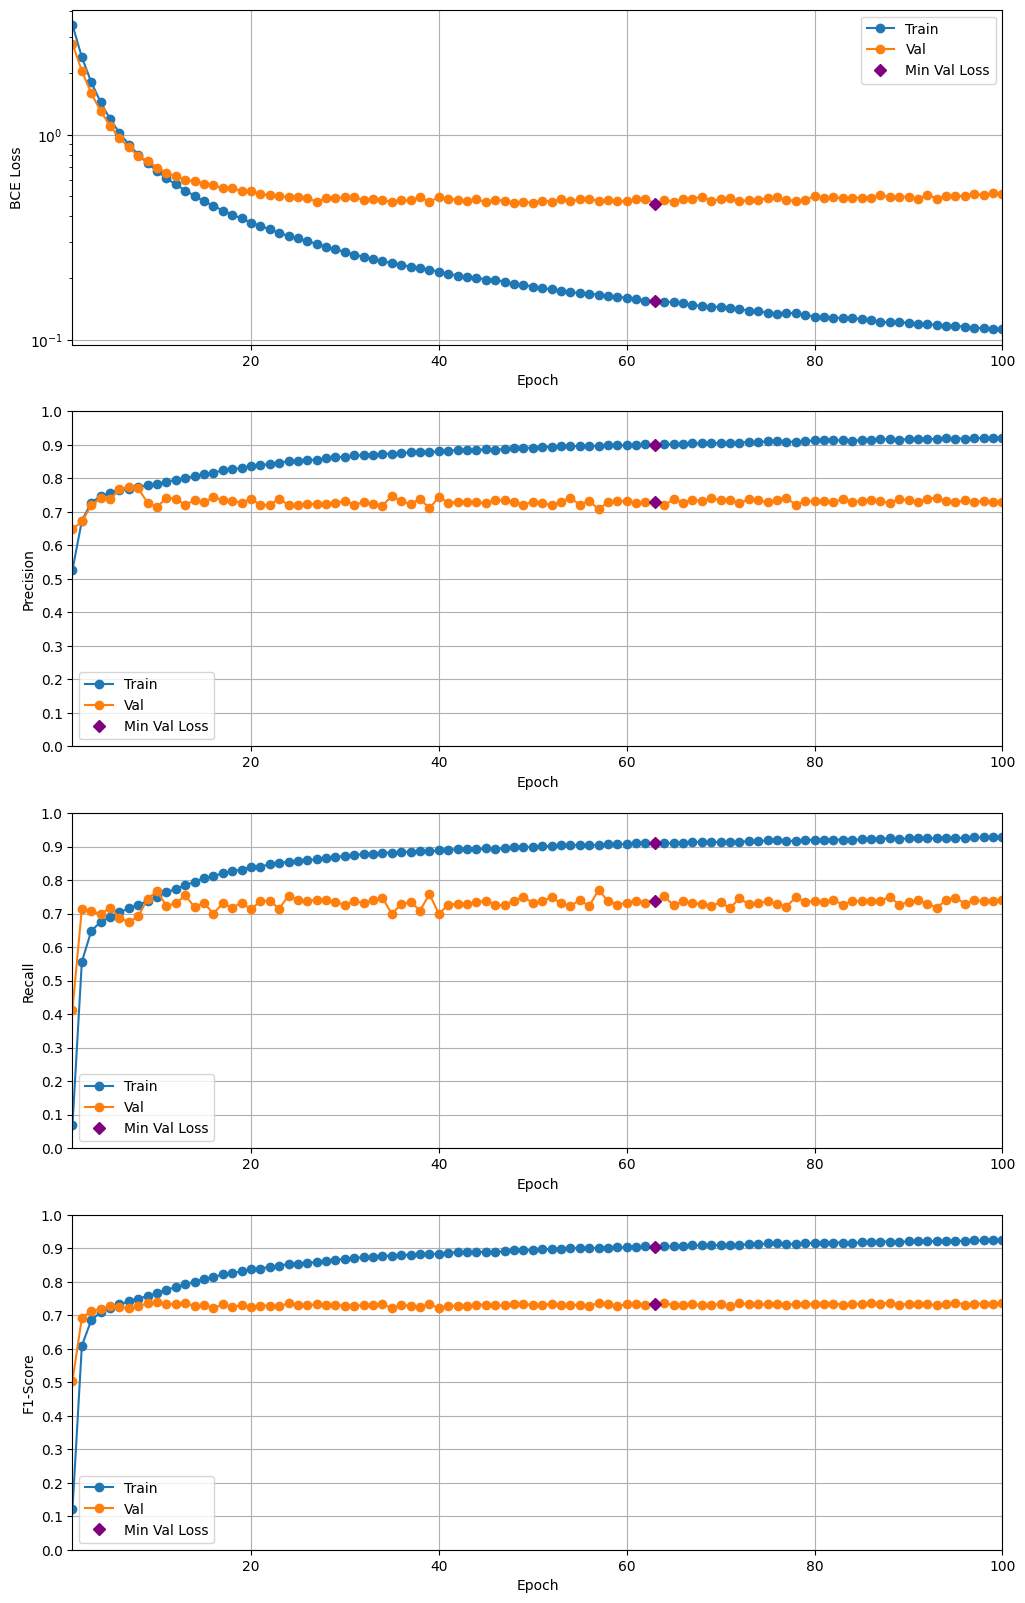

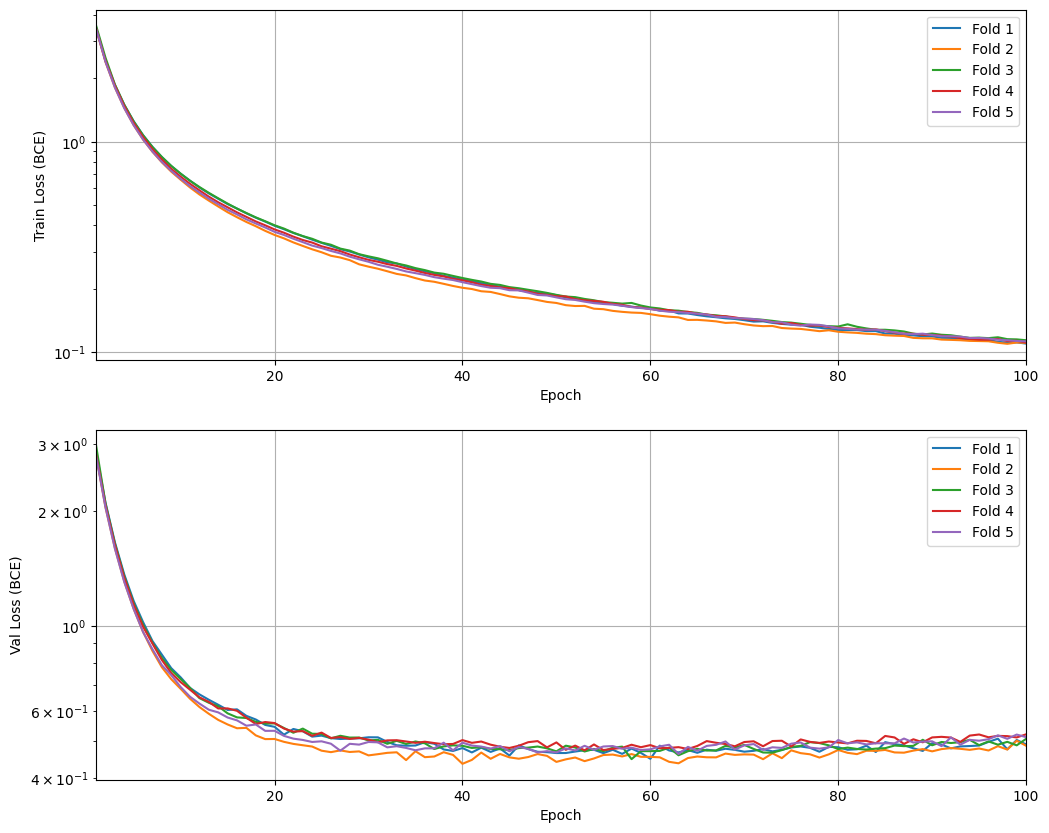

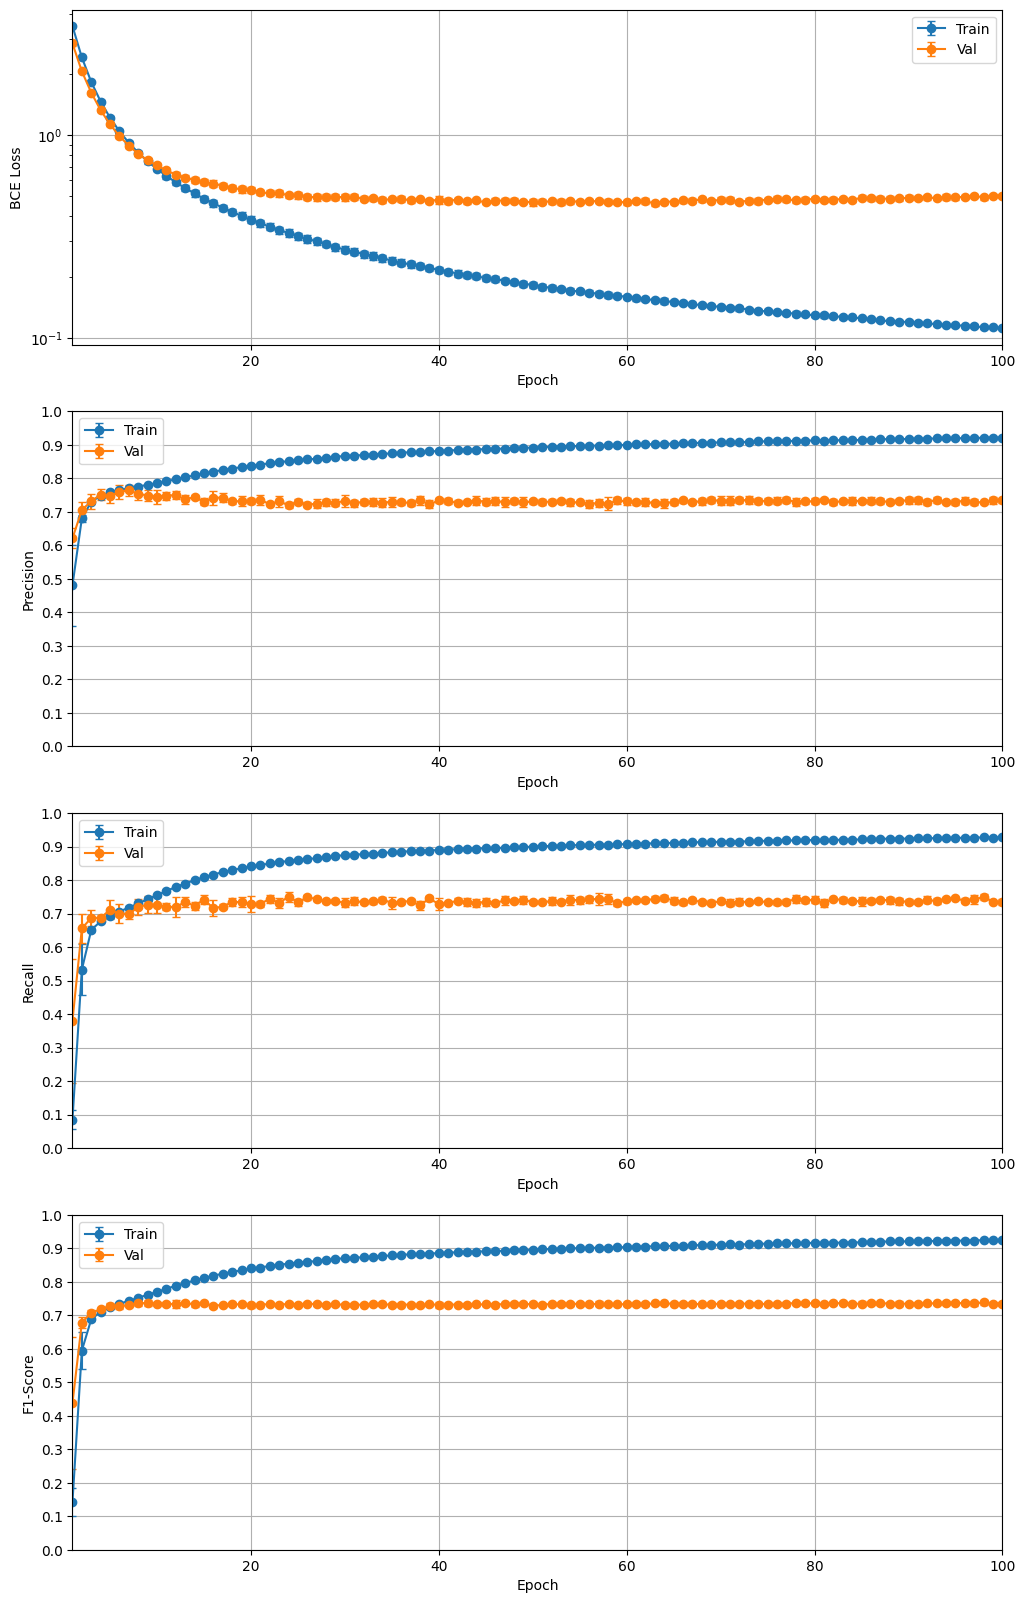

In [ ]:
"""
This module handles all preliminary operations for training including taking input from the user, checking it, and calling the correct mode function
"""

def print_input(configs : dict):
    # create top-level results directory
    mkdir(configs['results'])

    # print input to user for confirmation
    print('-'*50 + ' User Input ' + '-'*50)
    for key, val in configs.items():
        print(key + ':', val)
    print('-'*112)

# perform general checks on user input
print('\nChecking user input...\n')
general(configs)

# perform mode-specific checks on user input then run the chosen mode
if configs['training_mode'] == 'CrossVal':
    cross_val(configs)
    print_input(configs)
    cross_val_mode(configs)

elif configs['training_mode'] == 'Inference':
    inference(configs)
    print_input(configs)
    inference_mode(configs)

elif configs['training_mode'] == 'Single':
    single(configs)
    print_input(configs)
    single_mode(configs)

# save configs into results dir for reference after mode runs
with open(join(configs['results'], 'configs.json'), 'w') as con:
    json.dump(configs, con)